Hyper Parameterization Visualization/Process
Author: Harrison Blondeau
Date: April 22, 2022

This ipynb file reads in the evaluation metrics from the hyper parameter space search (Phase I and II) and aids in selecting the best combination. Approach and visual inspiration came from this article:
https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math


from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from pathlib import Path

In [2]:
# Load in the Phase I data and select appropriate rows
# Adjust plot output settings
%matplotlib inline

cwd = Path.cwd()
data = pd.read_csv(cwd / 'evaluation_I.csv')
#df = data.loc[(data['Embedding'] == 'sgns') & (data['Set'] == ' Dev/Test')].copy()
#df = data.loc[(data['Embedding'] == 'char') & (data['Set'] == ' Dev/Test')].copy()
df = data.loc[(data['Embedding'] == 'electra') & (data['Set'] == ' Dev/Test')].copy()

# Adjust Loss so that it goes from (0,1) not (-1,0)
df['Loss'] = df['Loss']* -1

# Create a categorical Epoch column
df['Epoch_Cat'] = df["Epoch"].astype("category")



In [3]:
# Begin data visualization/ overview
for i in df.columns:
    print(str(i).ljust(15), str(df[i].dtype).ljust(10))

Epoch           int64     
lr              float64   
do              float64   
hs              int64     
b               int64     
gn              float64   
Loss            float64   
MSE             float64   
Acc             float64   
Set             object    
Embedding       object    
Epoch_Cat       category  


In [4]:
print(df.head(10))

     Epoch     lr   do   hs   b     gn     Loss      MSE      Acc        Set  \
511      1  0.002  0.5  100  50  0.025  0.84084  2.50480  0.56439   Dev/Test   
513      2  0.002  0.5  100  50  0.025  0.83439  2.37306  0.54259   Dev/Test   
515      3  0.002  0.5  100  50  0.025  0.83011  2.16666  0.46400   Dev/Test   
517      4  0.002  0.5  100  50  0.025  0.82133  2.00952  0.42729   Dev/Test   
519      5  0.002  0.5  100  50  0.025  0.81866  1.90318  0.43184   Dev/Test   
521      1  0.001  0.1   10  50  0.025  0.83500  3.34043  0.56518   Dev/Test   
523      2  0.001  0.1   10  50  0.025  0.83802  3.33527  0.56502   Dev/Test   
525      3  0.001  0.1   10  50  0.025  0.83729  3.32659  0.55937   Dev/Test   
527      4  0.001  0.1   10  50  0.025  0.83383  3.31809  0.55780   Dev/Test   
529      5  0.001  0.1   10  50  0.025  0.83071  3.31290  0.54337   Dev/Test   

    Embedding Epoch_Cat  
511   electra         1  
513   electra         2  
515   electra         3  
517   electra  

<AxesSubplot:>

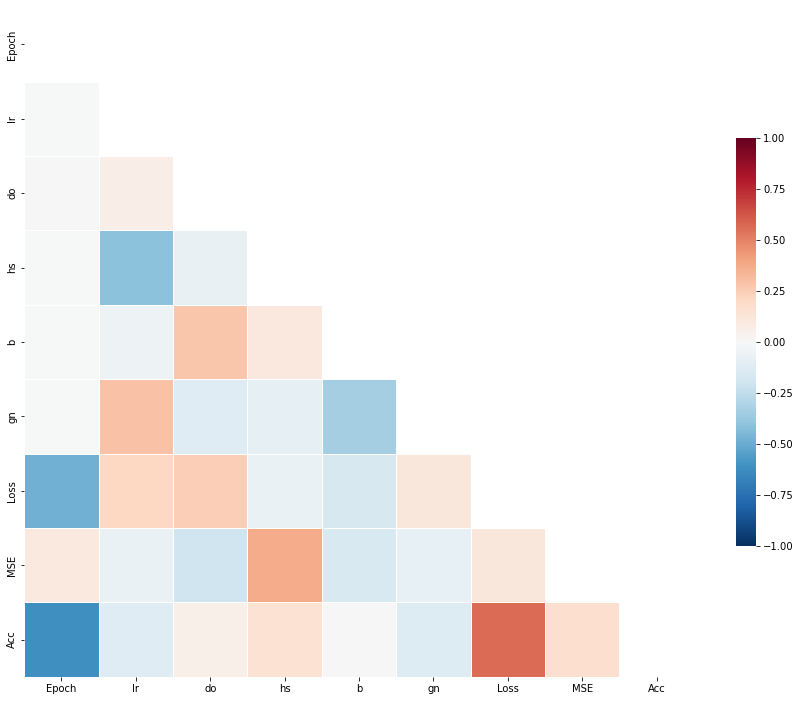

In [5]:
# Find the hyper parameters which influence the loss and MSE metrics the most
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap="RdBu_r", vmin= -1, vmax=1, center=0,annot=False, square=True, linewidths=.9, cbar_kws={"shrink": .5})

Take aways
SGNS:
1. Batch size and learning rate affect loss (COS) and accuracy the most
2. Hidden layer size has a strong correlation with MSE
3. Dropout has only minor effects on loss

CHAR:
1. Epoch has the highest effect on loss by far
2. Hidden size again has a strong effect on MSE

ELECTRA:
1. Hidden size has a big effect on MSE
2. Learning rate has a conflicting relationship with MSE and loss
3. Epoch has a strong effect on loss
4. Dropout has minor effect on Loss and MSE, also conflicting.

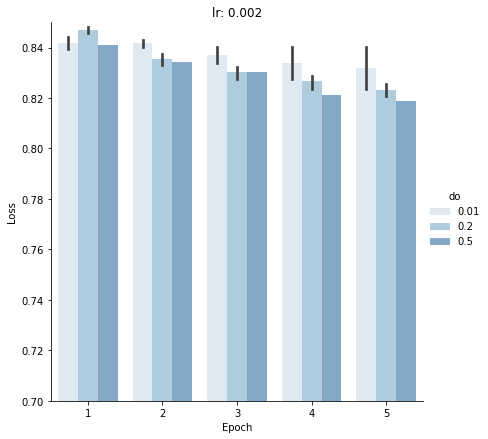

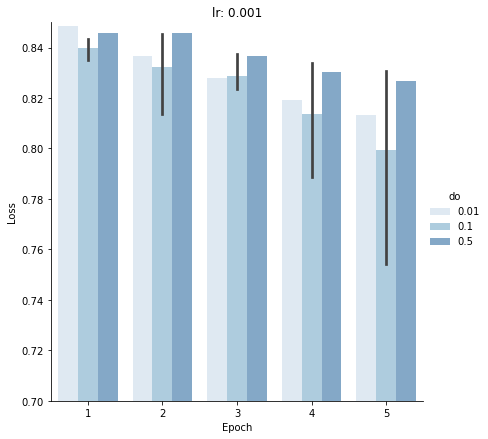

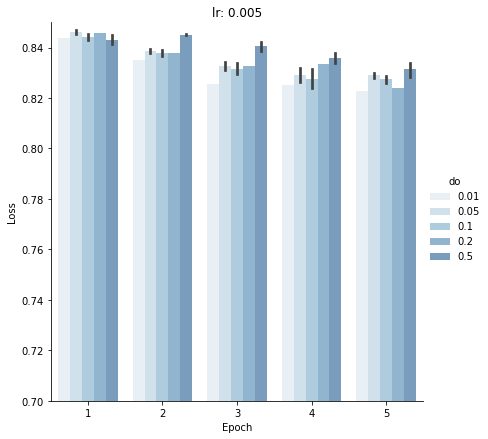

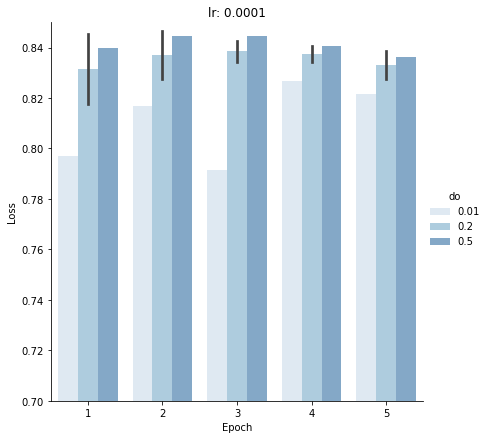

In [6]:
# Graph Epoch vs. Loss for each learning rate
for i in df["lr"].unique():
    title = "lr: " + str(i)
    epochVloss = sb.catplot(data=df.loc[(df['lr'] == i)], kind="bar", x="Epoch_Cat", y="Loss",
                       hue = "do", palette="Blues",alpha=0.6,height=6).set(title= title)
    epochVloss.set(ylim=(0.7, 0.85))
    
    epochVloss.set(xlabel="Epoch", ylabel="Loss")


[(0.8, 0.85)]

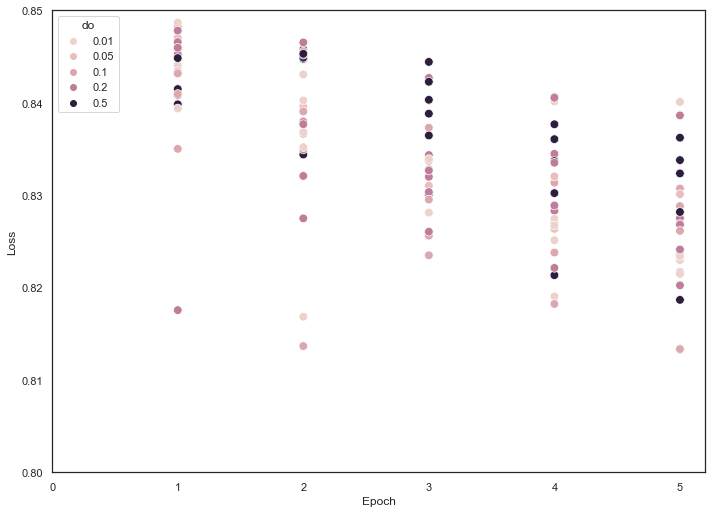

In [7]:
# Graph Epoch vs Loss and shade based on dropout to test earlier hypothesis
sb.set(rc={'figure.figsize':(11.7,8.5)})
sb.set_style("white")
epochVlossScatter = sb.scatterplot(data=df, x= "Epoch", y="Loss", hue="do", s=75)
epochVlossScatter.set(xlim=(0, 5.2))
epochVlossScatter.set(ylim=(0.8, 0.85))

Note: CHAR&ELECTRA: Increasing Epoch definitely leads to a worse model. Higher dropout seems to help this but its not clear 

0.002 :  0.8379314285714285
0.001 :  0.8363073333333333
0.005 :  0.8396122222222222
0.0001 :  0.8290258333333332


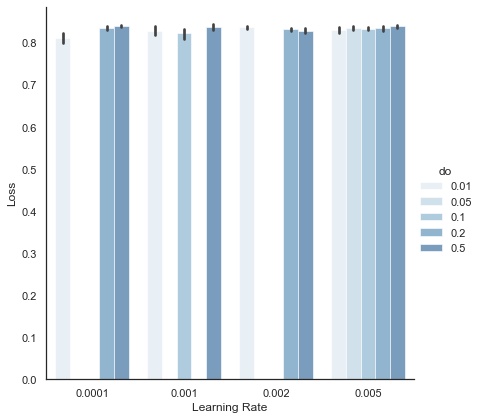

In [8]:
# Graph learning rate vs. Loss
lrVloss = sb.catplot(data=df, kind="bar", x="lr", y="Loss",
                       hue = "do", palette="Blues",alpha=0.6,height=6)
lrVloss.set(xlabel = "Learning Rate")

# Output average loss by lr (with or without epoch filtering)
for i in df['lr'].unique():
    #print(i,": ",df.loc[(df["lr"] == i), "Loss"].mean())
    print(i,": ",df.loc[(df["lr"] == i)&(df["Epoch"]<4), "Loss"].mean())


Note: 
CHAR: Higher DO values are able to learn as epochs increase whereas smaller values quickly experience overfitting

[(0.82, 0.875)]

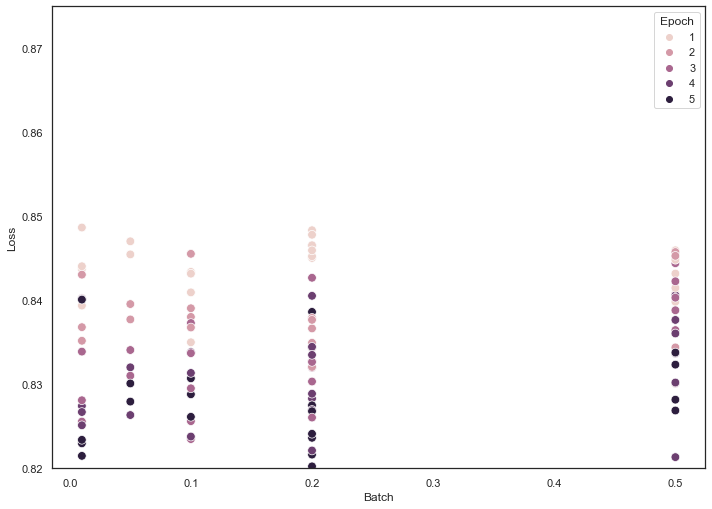

In [9]:
# Graph dropout vs. Loss
batchVloss = sb.scatterplot(data=df, x="do", y="Loss", hue="Epoch", s=75)
batchVloss.set(xlabel = "Batch")
batchVloss.set(ylim = (0.82,0.875))

Note: CHAR&ELECTRA: Batch size had little effect on loss. However, batch size <20 seems to have least variance

[Text(0.5, 0, 'Batch')]

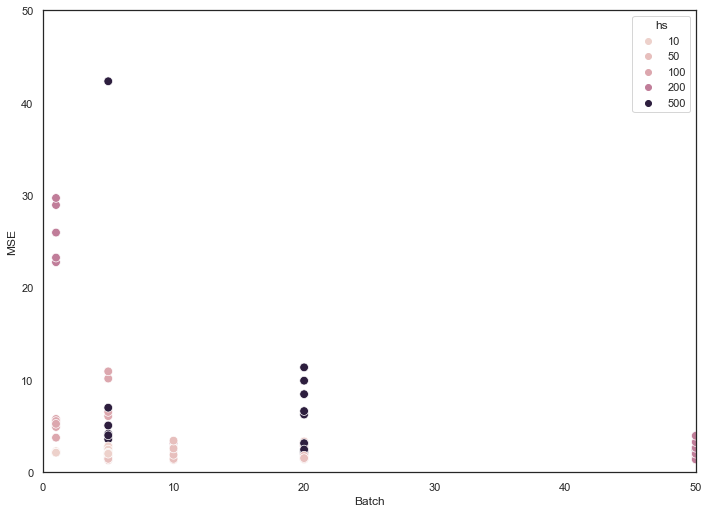

In [10]:
# Graph batch size vs. MSE
batchVmse = sb.scatterplot(data=df, x="b", y="MSE", hue="hs", s=75)
batchVmse.set(xlim=(0,50))
batchVmse.set(ylim=(0, 50))
batchVmse.set(xlabel = "Batch")

[Text(0.5, 0, 'Batch')]

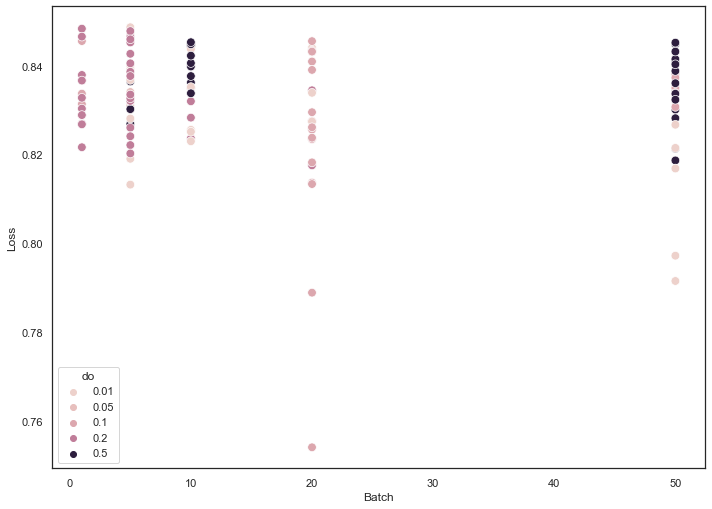

In [11]:
# Graph batch size vs Loss (shade for epoch)
batchVloss2 = sb.scatterplot(data=df, x="b", y="Loss", hue="do", s=75)
batchVloss2.set(xlabel="Batch")

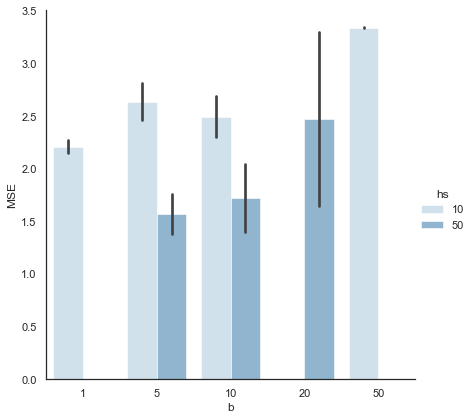

In [12]:
# Graph batch size vs Loss only for first 3 Epochs
#batchVloss3= sb.catplot(data=df.loc[(df["Epoch"]<=1)], kind="bar", x="b", y="Loss",hue = "do", palette="Blues",alpha=0.9,height=6)
#
# Graph batch size vs MSE only for Epochs less than 4. Also, shade for HS to see how thats affecting
batchVloss3 = sb.catplot(data=df.loc[(df["Epoch"]<3)&(df["hs"]<100)], kind="bar", x="b", y="MSE",
                       hue = "hs", palette="Blues",alpha=0.6,height=6)
# Rescale to see finer grain
#batchVloss3.set(ylim=(0,2))

Note: CHAR: Batch size of 20 does appear to be keeping MSE in check
      ELECTRA: Lower batch size lower MSE

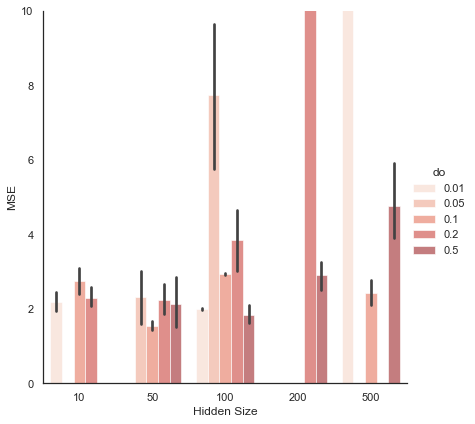

In [13]:
# Graph hidden layer size vs MSE 
hiddenVmse= sb.catplot(data=df, kind="bar", x="hs", y="MSE",
                       hue = "do", palette="Reds",alpha=0.6,height=6)
hiddenVmse.set(xlabel="Hidden Size")

# Rescale to see finer grain
hiddenVmse.set(ylim=(0,10))

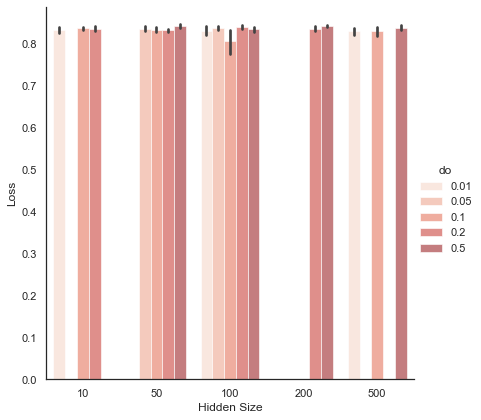

In [14]:
# Graph hidden layer size vs Loss 
hiddenVloss = sb.catplot(data=df, kind="bar", x="hs", y="Loss",
                       hue = "do", palette="Reds",alpha=0.6,height=6)
hiddenVloss.set(xlabel="Hidden Size")

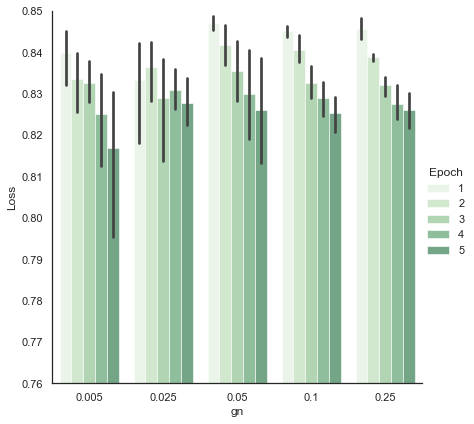

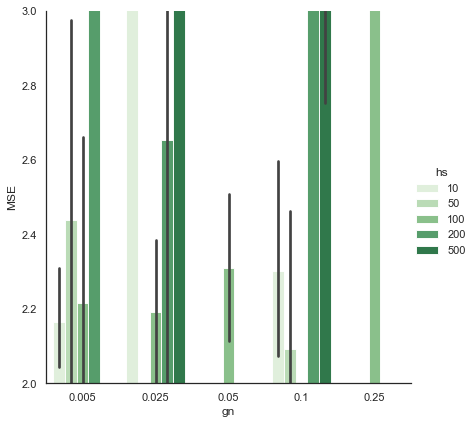

In [15]:
# Graph gn vs Loss only 
gnVloss = sb.catplot(data=df, kind="bar", x="gn", y="Loss",
                       hue = "Epoch", palette="Greens",alpha=0.6,height=6)
gnVloss.set(ylim=(0.76,0.85))

# Graph batch size vs MSE only for Epoch 5
gnVloss = sb.catplot(data=df, kind="bar", x="gn", y="MSE",
                       hue = "hs", palette="Greens",alpha=0.9,height=6)

# Rescale to see finer grain
gnVloss.set(ylim=(2,3))

Phase I:

Take aways: 
SGNS
- As batch size increases, MSE variation decreases
- As batch size decreases, Loss increases
- Dropout in (0.1,0.5) has lowest MSE and highest Loss
- Learning rates <=0.002 have better Loss
- Lower HS results in lower MSE

CHAR
- Lower Epoch is better
- HS under 10 is ideal
- Batch size around 20 is keeping MSE in check
- gn between 0.05 and 0.25 yields higher loss when epochs are kept <4
- Lower lr yields higher loss (insignificant margin however). Try (0.0001,0.001)

ELECTRA
- Increasing learning rate (>= 0.002) has a positive effect on loss.
- As Epochs increase, loss decreases. Slowest decrease corresponds to highest do
- MSE vs DO. Little effect if any
- DO (0,0.2) for best loss
- MSE vs HS. HS < 50 is ideal
- Batch size <20 has lower variance, Lower MSE, and better loss at the margins
- gn of 0.05 is gold again

In [16]:
phase2Data = pd.read_csv(cwd / 'evaluation_II.csv')
#p2df = phase2Data.loc[(phase2Data['Embedding'] == 'sgns') & (phase2Data['Set'] == ' Dev/Test')].copy()
#p2df = phase2Data.loc[(phase2Data['Embedding'] == 'char') & (phase2Data['Set'] == ' Dev/Test')].copy()
p2df = phase2Data.loc[(phase2Data['Embedding'] == 'electra') & (phase2Data['Set'] == ' Dev/Test')].copy()

# Adjust Loss so that it goes from (0,1) not (-1,0)
p2df['Loss'] = p2df['Loss']* -1

# Create a categorical Epoch column
p2df['Epoch_Cat'] = p2df["Epoch"].astype("category")

In [17]:
print(p2df.head())

     Epoch     lr      do  hs   b     gn     Loss      MSE      Acc  \
541      1  0.002  0.0001   5  10  0.005  0.84249  3.15135  0.56518   
543      2  0.002  0.0001   5  10  0.005  0.83398  3.10089  0.53475   
545      3  0.002  0.0001   5  10  0.005  0.81750  3.06688  0.52094   
547      4  0.002  0.0001   5  10  0.005  0.81054  3.04420  0.51796   
549      5  0.002  0.0001   5  10  0.005  0.81616  3.01474  0.48549   

           Set Embedding Group Epoch_Cat  
541   Dev/Test   electra  G542         1  
543   Dev/Test   electra  G544         2  
545   Dev/Test   electra  G546         3  
547   Dev/Test   electra  G548         4  
549   Dev/Test   electra  G550         5  


In [21]:
# Print Data Types
for i in p2df.columns:
    print(str(i).ljust(15), str(p2df[i].dtype).ljust(10))


Epoch           int64     
lr              float64   
do              float64   
hs              int64     
b               int64     
gn              float64   
Loss            float64   
MSE             float64   
Acc             float64   
Set             object    
Embedding       object    
Group           object    
Epoch_Cat       category  


In [23]:
# Output average loss by epoch
for i in p2df["Epoch"].unique():
    print(i,": ",p2df.loc[p2df["Epoch"] == i, "Loss"].mean())

1 :  0.8408527777777777
2 :  0.8358477777777777
3 :  0.8296765277777779
4 :  0.825783611111111
5 :  0.8236722222222223


In [25]:
# Print top groups/indexes/hyper param combos by loss and MSE
top = p2df.sort_values("Loss", axis=0, ascending=False)
print(top.head(10),"\n")
    
print(p2df["Loss"].nlargest(n=10))
print(p2df["MSE"].nsmallest(n=10))

      Epoch     lr      do  hs   b     gn     Loss      MSE      Acc  \
681       1  0.002  0.1000  50  10  0.005  0.84685  2.40898  0.56471   
741       1  0.002  0.2000  25  10  0.005  0.84620  3.23360  0.56439   
931       1  0.004  0.1000  50  20  0.005  0.84596  2.28552  0.56659   
861       1  0.004  0.1000   5  10  0.005  0.84590  3.16272  0.56518   
981       1  0.004  0.2000  25  10  0.005  0.84590  2.94046  0.56376   
961       1  0.004  0.2000  10  10  0.005  0.84577  3.17181  0.56329   
841       1  0.004  0.0001  50  10  0.005  0.84572  1.64547  0.55984   
721       1  0.002  0.2000  10  10  0.005  0.84551  3.26232  0.56455   
1251      1  0.010  0.2000  50  20  0.005  0.84549  1.33066  0.56502   
1101      1  0.010  0.1000   5  10  0.005  0.84527  2.35836  0.56518   

            Set Embedding  Group Epoch_Cat  
681    Dev/Test   electra   G682         1  
741    Dev/Test   electra   G742         1  
931    Dev/Test   electra   G932         1  
861    Dev/Test   electra  